# ktree benchmarking

benchmark ktrees using various datasets

In [2]:


from custompackage.load_data import *
from custompackage.load_architecture import *
from custompackage.traintestloop import *

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
import torchvision
from torchvision import transforms
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib
import matplotlib.pyplot as plt
from torch.optim.optimizer import required
from torch.utils.data.dataset import random_split
import scipy
import os
import glob
import pandas as pd
from hyperopt import hp, tpe, fmin, Trials
import pickle

% matplotlib inline

In [11]:
torch.cuda.set_device(3)
torch.cuda.current_device()

3

# Test out dataloaders to see if they have similar structures

In [83]:
bs = 256
# t1 = 3
# t2 = 5
t1 = classes[0][0]
t2 = classes[0][1]
weighting = 'paired'
split = 1
ds = 'mnist'


trainsets, validsets, testset = dataset_weighted_split_all(bs, t1, t2, weighting, split, ds)

/home/ilenna/projects/DRNN/custompackage/load_data.py:229: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  selector_1 = np.where(label_default.numpy() == Target_class_1)
/home/ilenna/projects/DRNN/custompackage/load_data.py:230: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  selector_2 = np.where(label_default.numpy() == Target_class_2)
/home/ilenna/projects/DRNN/custompackage/load_data.py:240: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  label_binary = np.where(label_pair.numpy() == Target_class_1, 1, 0)


RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

torch.Size([10000, 784])
torch.Size([2000, 784])
tensor([1, 0, 0])


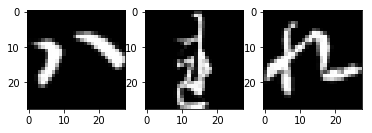

In [78]:
trainset = trainsets[0]
print(trainset.dataset.tensors[0].shape)
validset = validsets[0]
print(validset.dataset.tensors[0].shape)
i = 0
print(trainset.dataset.tensors[1][i:i+3])

fig = plt.figure()
axes = []
axes.append(fig.add_subplot(1,3,1))
axes[0].imshow(trainset.dataset.tensors[0][i].view(28,-1), cmap='gray')
axes.append(fig.add_subplot(1,3,2))
axes[1].imshow(trainset.dataset.tensors[0][i+1].view(28,-1), cmap='gray')
axes.append(fig.add_subplot(1,3,3))
axes[2].imshow(trainset.dataset.tensors[0][i+2].view(28,-1), cmap='gray')

# Adjust k_tree code to be more general and applicable to all datasets

In [105]:
class ktree_gen(nn.Module):
    '''
    Tree NN
    '''
    
    def __init__(self, ds='mnist', Activation="relu", Sparse=True,
                 Input_order=None, Repeats=1):
        super(ktree_gen, self).__init__()
        '''
        Inputs: Input_size, Hidden_size, Output_size
        '''
        # Initialize architecture parameters
        self.ds = ds
        self.Activation = Activation
        self.Sparse = Sparse
        self.Input_order = Input_order
        self.Repeats = Repeats
        
        # Initialize weights
        # Set biases to 0
        # Set kaiming initialize weights with gain to correct for sparsity
        # Set freeze masks
        
        #Specify tree dimensions
        if (ds == 'mnist') or (ds == 'fmnist') or (ds == 'kmnist') or (ds == 'emnist'):
            self.k = [784, 112, 16, 8, 4, 2, 1]
        elif (ds == 'svhn') or (ds == 'cifar10'):
            self.k = [3072, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
        elif ds == 'usps':
            self.k = [256, 128, 64, 32, 16, 8, 4, 2, 1]
        else:
            print('Select a dataset')
            return(None)
        
        
        self.names = np.empty((self.Repeats, len(self.k)-1),dtype=object)
        self.freeze_mask_set = []
        for j in range(self.Repeats):
            for i in range(len(self.k)-1):
                name = ''.join(['w',str(j),'_',str(i)])
                self.add_module(name, nn.Linear(self.k[i],self.k[i+1]))
                self._modules[name].bias = nn.Parameter(torch.zeros_like(self._modules[name].bias)) 
                self._modules[name].weight.data, freeze_mask = self.initialize(self._modules[name])
                self.names[j,i] = name
                if j < 1:
                    self.freeze_mask_set.append(freeze_mask)
        
        self.root = nn.Linear(Repeats, 1)
        
        # Initialize nonlinearities
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        '''
        Forward step for network. Establishes Architecture.
        Inputs: Input, Hidden
        Outputs: Output, Hidden
        '''
        
        y_out = []
        for j in range(self.Repeats):
            y = x
            for i in range(len(self.k)-1):
                if self.Activation == 'relu':
                    y = self.relu(self._modules[self.names[j,i]](y))
                else:
                    y = self._modules[self.names[j,i]](y)
            y_out.append(y)

        output = self.sigmoid(self.root(torch.cat((y_out), dim=1)))

        return(output)
    
    def initialize(self, layer):
        # Kaiming initialize weights accounting for sparsity
        weights = layer.weight.data
        if self.Sparse:
            if weights.shape[1] == 3072:
                inp_block = torch.ones((1,3))
            elif (weights.shape[1] == 784) or (weights.shape[1] == 112):
                inp_block = torch.ones((1,7))
            else:
                inp_block = torch.ones((1,2))
            inp_mask = kronecker(torch.eye(weights.shape[0]), inp_block)

            density = len(np.where(inp_mask)[0])/len(inp_mask.reshape(-1))

            # Generate Kaiming initialization with gain = 1/density
            weights = torch.nn.init.normal_(weights, mean=0.0, std=math.sqrt(2/(weights.shape[1]*density)))

            weights[inp_mask == 0] = 0
        else:
            weights = torch.nn.init.normal_(weights, mean=0.0, std=math.sqrt(2/(weights.shape[1])))
        
        mask_gen = torch.zeros_like(weights)
        freeze_mask = mask_gen == weights
        
        return(weights, freeze_mask)
    
    
model = ktree_gen(ds='svhn',Repeats=2).cuda()

a = torch.ones((1,3072)).cuda()
model(a)



tensor([[0.4576]], device='cuda:3', grad_fn=<SigmoidBackward>)

# Scripts for LDA

In [ ]:
# bs = 256
# weighting = 'paired'
# trials = 10
# ds_set = ['mnist', 'fmnist', 'kmnist','emnist','svhn','usps']


# paired_test = np.zeros((len(ds_set),10,10))
# for k, ds in enumerate(ds_set):
#     for i in range(10):
#         t1 = i
#         for j in range(i+1,10):
#             t2 = j

#             trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds)

#             X_train = trainloaders[0].dataset.tensors[0]
#             y_train = trainloaders[0].dataset.tensors[1]
#             X_test = testloader.dataset.tensors[0]
#             y_test = testloader.dataset.tensors[1]


#             # initialize lda
#             lda = LinearDiscriminantAnalysis()

#             # fit to images, labels
#             lda.fit(X_train, y_train)

#             # see accuracy for validation set
#             score_test = lda.score(X_test, y_test)

#             print(ds, i, j, score_test)

#             paired_test[k,i,j] = score_test
            
#             np.save('./results/20200324/confused_pairs.npy', paired_test)

In [ ]:
# # Uppercase Letters

# bs = 256
# weighting = 'paired'
# trials = 10
# ds_set = ['emnist']


# paired_test = np.zeros((len(ds_set),10,10))
# for k, ds in enumerate(ds_set):
#     for i in range(10, 36):
#         t1 = i
#         for j in range(i+1,36):
#             t2 = j

#             trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds)

#             X_train = trainloaders[0].dataset.tensors[0]
#             y_train = trainloaders[0].dataset.tensors[1]
#             X_test = testloader.dataset.tensors[0]
#             y_test = testloader.dataset.tensors[1]


#             # initialize lda
#             lda = LinearDiscriminantAnalysis()

#             # fit to images, labels
#             lda.fit(X_train, y_train)

#             # see accuracy for validation set
#             score_test = lda.score(X_test, y_test)

#             print(ds, i, j, score_test)

#             paired_test[k,i,j] = score_test
            
#             np.save('./results/20200324/confused_pairs_emnist_upper.npy', paired_test)

# Determine confused pairs

In [ ]:
paired_test = np.load('./results/20200324/confused_pairs.npy')

ds_set = ['mnist', 'fmnist', 'kmnist','emnist','svhn','usps']


classes = []
for i, ds in enumerate(ds_set):
    focus = paired_test[i]

    a = np.min(focus[np.nonzero(focus)])
    c = np.where(focus == a)

    classes.append([c[0][0], c[1][0], ds])

classes = np.array(classes, dtype=object)
# np.save('./results/20200324/classes.npy', classes, allow_pickle=True)

[[14 17 'emnist']]
0.5517492711370262
0.5517492711370262
[[3 5 'mnist']
 [4 6 'fmnist']
 [4 9 'kmnist']
 [3 5 'emnist']
 [6 7 'svhn']
 [0 1 'usps']]
[14 17 'emnist']


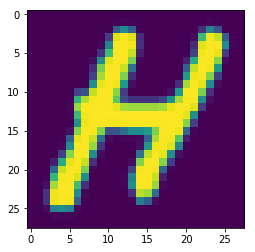

In [173]:
# paired_test = np.load('./results/20200324/confused_pairs_emnist_upper.npy')

# ds_set = ['emnist']


# classes = []
# for i, ds in enumerate(ds_set):
#     focus = paired_test[i]

#     a = np.min(focus[np.nonzero(focus)])
#     c = np.where(focus == a)

#     classes.append([c[0][0]+10, c[1][0]+10, ds])

# classes = np.array(classes, dtype=object)

# print(classes)
# print(a)
# print(focus[classes[0][0]-10,classes[0][1]-10])
# plt.imshow(trainsets[0].dataset.tensors[0][9].view(-1,28).t())
# class_orig = np.load('./results/20200324/classes.npy', allow_pickle=True)
# print(class_orig)
# print(classes[0])

# intermed = np.concatenate((class_orig, classes), 0)
# np.save('./results/20200324/classes_emnist.npy', intermed, allow_pickle=True)
# # np.save('./results/20200324/classes.npy', classes, allow_pickle=True)



In [6]:
# paired_test = np.load('./results/20200324/confused_pairs.npy')
paired_test = np.load('./results/20200509/confused_pairs.npy')


ds_set = ['mnist', 'fmnist', 'kmnist','emnist','svhn','usps']


classes = []

paired_test
for i, ds in enumerate(ds_set):
    focus = paired_test[i]

    a = np.min(focus[np.nonzero(focus)])
    b = np.sort(focus[np.nonzero(focus)])
    e = b[len(b)-2]
    c = np.where(focus == a)
    d = np.where(focus == e)

    classes.append([c[0][0], c[1][0], ds, a, d[0][0], d[1][0], e])

classes = np.array(classes, dtype=object)

print(classes)
# np.save('./results/20200324/classes_perf.npy', classes, allow_pickle=True)

# print(classes)

[[3 5 'mnist' 0.8769716088328076 0 4 0.971967380224261]
 [4 6 'fmnist' 0.658 1 7 0.967]
 [4 9 'kmnist' 0.669 0 1 0.8565]
 [3 5 'emnist' 0.955910027780267 6 9 0.9933280660170309]
 [6 7 'svhn' 0.5057557557557557 1 9 0.6596952494771438]
 [0 1 'usps' 0.7961476725521669 0 7 0.9802371541501976]]


In [16]:
paired_test = np.load('./results/20200324/confused_pairs_emnist_upper.npy')

ds_set = ['emnist']


classes = []
for i, ds in enumerate(ds_set):
    focus = paired_test[i]

    a = np.min(focus[np.nonzero(focus)])
    print(a)
    b = np.sort(focus[np.nonzero(focus)])
    e = b[len(b)-2]
    c = np.where(focus == a)
    d = np.where(focus == e)
    
    classes.append([c[0][0]+10, c[1][0]+10, ds, a, d[0][0]+10, d[1][0]+10, e ])

classes = np.array(classes, dtype=object)

print(classes)
print(a)
print(focus[classes[0][0]-10,classes[0][1]-10])
# plt.imshow(trainsets[0].dataset.tensors[0][9].view(-1,28).t())
# class_orig = np.load('./results/20200324/classes.npy', allow_pickle=True)
# print(class_orig)
# print(classes[0])

# intermed = np.concatenate((class_orig, classes), 0)
# np.save('./results/20200324/classes_emnist_perf.npy', intermed, allow_pickle=True)
# np.save('./results/20200324/classes.npy', classes, allow_pickle=True)


0.5517492711370262
[[14 17 'emnist' 0.5517492711370262 21 24 0.9838904550946436]]
0.5517492711370262
0.5517492711370262


NameError: name 'trainsets' is not defined

In [8]:
paired_test = np.load('./results/20200509/confused_pairs_cifar10.npy')

ds_set = ['cifar10']


classes = []
for i, ds in enumerate(ds_set):
    focus = paired_test[i]

    a = np.min(focus[np.nonzero(focus)])
    print(a)
    b = np.sort(focus[np.nonzero(focus)])
    e = b[len(b)-2]
    c = np.where(focus == a)
    d = np.where(focus == e)
    
    classes.append([c[0][0], c[1][0], ds, a, d[0][0], d[1][0], e ])

classes = np.array(classes, dtype=object)

print(classes)

0.5455
[[3 5 'cifar10' 0.5455 0 6 0.781]]


In [67]:
paired_test = np.load('./results/20200509/confused_pairs_all.npy')

print(paired_test.shape)

ds = 0
pt_mean = np.mean(paired_test, axis=1)

ds_set = ['mnist', 'fmnist', 'kmnist','svhn','usps', 'cifar10']


classes = []

paired_test
for i, ds in enumerate(ds_set):
    focus = pt_mean[i]

    a = np.min(focus[np.nonzero(focus)])
    b = np.sort(focus[np.nonzero(focus)])
    e = b[len(b)-2]
    c = np.where(focus == a)
    d = np.where(focus == e)

    classes.append([c[0][0], c[1][0], ds, a, d[0][0], d[1][0], e])

classes = np.array(classes, dtype=object)

print(classes)
# np.save('./results/20200511/classes.npy', classes[:,:3], allow_pickle=True)

# np.load('./results/20200511/classes.npy', allow_pickle=True)


(6, 10, 10, 10)
[[3 5 'mnist' 0.8772344900105151 0 4 0.9688073394495413]
 [0 6 'fmnist' 0.67095 2 9 0.9676]
 [2 6 'kmnist' 0.68395 0 1 0.86295]
 [5 6 'svhn' 0.5153634487502866 1 9 0.6535255452644159]
 [3 5 'usps' 0.8429447852760736 0 9 0.9570895522388059]
 [3 5 'cifar10' 0.5216999999999998 6 8 0.749]]


In [63]:
paired_test = np.load('./results/20200509/confused_pairs_emnist_upper.npy')
paired_test.shape

pt_mean = np.mean(paired_test, axis=1)

ds_set = ['emnist']
classes = []
for i, ds in enumerate(ds_set):
    focus = pt_mean[i]

    a = np.min(focus[np.nonzero(focus)])
    print(a)
    b = np.sort(focus[np.nonzero(focus)])
    e = b[len(b)-2]
    c = np.where(focus == a)
    d = np.where(focus == e)
    
    classes.append([c[0][0]+10, c[1][0]+10, ds, a, d[0][0]+10, d[1][0]+10, e ])

classes = np.array(classes, dtype=object)


# intermed = np.concatenate((class_orig, classes), 0)
# np.save('./results/20200511/classes_emnist_perf.npy', intermed, allow_pickle=True)
# np.save('./results/20200511/classes.npy', classes, allow_pickle=True)


0.5707725947521867
[[14 17 'emnist' 0.5707725947521867 21 24 0.9814941602899717]]
(6, 3) (1, 3)
[[3 5 'mnist']
 [0 6 'fmnist']
 [2 6 'kmnist']
 [5 6 'svhn']
 [3 5 'usps']
 [3 5 'cifar10']
 [14 17 'emnist']]
[[5 6 'svhn']
 [3 5 'usps']
 [3 5 'cifar10']]
[14 17 'emnist']
[[3 5 'mnist']
 [0 6 'fmnist']
 [2 6 'kmnist']
 [14 17 'emnist']
 [5 6 'svhn']
 [3 5 'usps']
 [3 5 'cifar10']]


In [66]:
# print(classes)
# classes_orig = np.load('./results/20200511/classes.npy', allow_pickle=True)
# print(classes_orig.shape, classes[:,:3].shape)
# classes_orig = np.concatenate((classes_orig,classes[:,:3]),0)
# a = classes_orig[3:6].copy()
# b = classes_orig[6].copy()
# classes_orig[3] = b
# classes_orig[4:] = a

# print(classes_orig)
# # np.save('./results/20200511/classes.npy', classes_orig, allow_pickle=True)

[[14 17 'emnist' 0.5707725947521867 21 24 0.9814941602899717]]
(6, 3) (1, 3)
[[3 5 'mnist']
 [0 6 'fmnist']
 [2 6 'kmnist']
 [14 17 'emnist']
 [5 6 'svhn']
 [3 5 'usps']
 [3 5 'cifar10']]


In [14]:
classes = np.load('./results/20200324/classes_emnist.npy', allow_pickle=True)
classes[3] = classes[6]
classes[6] = [2, 3, 'cifar10']
classes = classes[0:7]

print(classes)

# np.save('./results/20200504/classes.npy', classes, allow_pickle=True)
classes = np.load('./results/20200504/classes.npy', allow_pickle=True)
print(classes)

[[3 5 'mnist']
 [4 6 'fmnist']
 [4 9 'kmnist']
 [14 17 'emnist']
 [6 7 'svhn']
 [0 1 'usps']
 [2 3 'cifar10']]
[[3 5 'mnist']
 [4 6 'fmnist']
 [4 9 'kmnist']
 [14 17 'emnist']
 [6 7 'svhn']
 [0 1 'usps']
 [2 3 'cifar10']]


In [116]:
paired_test = np.load('./results/20200509/confused_pairs_all.npy')

print(paired_test.shape)

ds = 0
pt_mean = np.mean(paired_test, axis=1)

ds_set = ['mnist', 'fmnist', 'kmnist','svhn','usps', 'cifar10']


classes = []

paired_test
for i, ds in enumerate(ds_set):
    focus = pt_mean[i]

    a = np.min(focus[np.nonzero(focus)])
    mean_sorted = np.sort(focus[np.nonzero(focus)])
    
    minperfs = []
    minclass = []
    for j in range(5):
        minperfs.append(mean_sorted[j])
    
    for k in range(5):
        g = np.where(focus == minperfs[k])
        minclass.append(np.array([g[0][0], g[1][0]]))
    e = b[len(b)-2]
    f = b[len(b)-1]
    c = np.where(focus == a)
    d = np.where(focus == e)
    
    classes_interm = []
    for m in range(5):
        classes_interm.append([minclass[m], minperfs[m]])
    classes.append([ds, np.array(classes_interm)])

classes = np.array(classes, dtype=object)

rank = 0
ds_idx = 0
classes[ds_idx][1][rank][0]
# print(classes)
# np.save('./results/20200511/classes.npy', classes[:,:3], allow_pickle=True)

# np.load('./results/20200511/classes.npy', allow_pickle=True)


(6, 10, 10, 10)


array([3, 5])

In [126]:
bs = 256
# t1 = 3
# t2 = 5
i = 3
t1 = classes[i][0]
t2 = classes[i][1]
weighting = 'paired'
split = 1
ds = classes[i][2]


trainsets, validsets, testset = dataset_weighted_split_all(bs, t1, t2, weighting, split, ds)

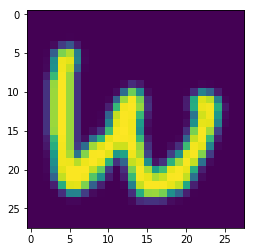

In [130]:
trainset = trainsets[0]
a = trainset.dataset.tensors[0][2]

plt.imshow(a.reshape(-1,28))

# Script to run through multitrees, will be used for pairs of datasets

Return to this after adjusting ktree architecture

In [ ]:
# Select Class Set
class_set = 0

# Initialize settings
bs = 256
weighting = 'paired'
trials = 10
epochs = 5000
trees_set = [1,2,4,8,16,32]

classes = np.load('./results/20200324/classes.npy', allow_pickle=True)

if class_set == 0:
    classes = classes[0:2] # mnist fmnist
elif class_set == 1:
    classes = classes[2:4] # kmnist emnist
else:
    classes = classes[4:6] # svhn usps



loss = np.zeros((len(classes), trials, len(trees_set)))
acc = np.zeros((len(classes), trials, len(trees_set)))

    
for j, (t1, t2, ds) in enumerate(classes):
    print(t1, t2, ds)
    trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds)
    for i in range(trials):
        for k, trees in enumerate(trees_set):
            print(j, i, k)
            model = ktree_gen(ds=ds, Repeats=trees).cuda()

            loss_curve, acc_curve, loss[j,i,k], acc[j,i,k], model_t = train_test_ktree(model, trainloaders[i],
                                                                                  testloader, epochs = 5000)

            np.save('./results/20200325/k_tree_acc_'+str(class_set)+'.npy', acc)
            np.save('./results/20200325/k_tree_loss_'+str(class_set)+'.npy', loss)


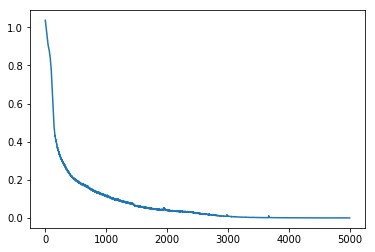

In [110]:
len(loss_curve)
plt.plot(loss_curve)

# Linear control

In [ ]:
# Initialize settings
trials = 10

classes = np.load('./results/20200324/classes.npy', allow_pickle=True)

score_test[j,i] = np.zeros((len(classes), trials))

    
for j, (t1, t2, ds) in enumerate(classes):
    print(t1, t2, ds)
    trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds)
    for i in range(trials):
        print(j, i)
        X_train = trainloaders[i].dataset.tensors[0]
        y_train = trainloaders[i].dataset.tensors[1]
        X_test = testloader.dataset.tensors[0]
        y_test = testloader.dataset.tensors[1]

        # initialize lda
        lda = LinearDiscriminantAnalysis()

        # fit to images, labels
        lda.fit(X_train, y_train)

        # see accuracy for validation set
        score_test[j,i] = lda.score(X_test, y_test)
        print(score_test[j,i])

        np.save('./results/20200325/lda_score_test.npy', score_test)


In [185]:
# Initialize settings
bs = 256
weighting = 'paired'
trials = 10

classes = np.load('./results/20200324/classes_emnist.npy', allow_pickle=True)

classes = classes[-1].reshape(1,-1)

print(classes)
score_test = np.zeros((len(classes), trials))

    
for j, (t1,t2,ds) in enumerate(classes):
    
    
    print(t1, t2, ds)
    print('lda')
    trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds)
    for i in range(trials):
        print(j, i)
        X_train = trainloaders[i].dataset.tensors[0]
        y_train = trainloaders[i].dataset.tensors[1]
        X_test = testloader.dataset.tensors[0]
        y_test = testloader.dataset.tensors[1]

        # initialize lda
        lda = LinearDiscriminantAnalysis()

        # fit to images, labels
        lda.fit(X_train, y_train)

        # see accuracy for validation set
        score_test[j,i] = lda.score(X_test, y_test)
        print(score_test[j,i])

        np.save('./results/20200325/lda_score_test_emnist.npy', score_test)

[[14 17 'emnist']]
14 17 emnist
lda
0 0
0.5947521865889213
0 1


/home/ilenna/.conda/envs/py36_mod2/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.6173469387755102
0 2
0.5663265306122449
0 3
0.6188046647230321
0 4
0.5940233236151603
0 5
0.5488338192419825
0 6
0.5743440233236151
0 7
0.577259475218659
0 8
0.5983965014577259
0 9
0.5962099125364432


# FC control

In [ ]:
# Initialize settings
bs = 256
weighting = 'paired'
trials = 10
epochs = 500

classes = np.load('./results/20200324/classes.npy', allow_pickle=True)

loss = np.zeros((len(classes), trials))
acc = np.zeros((len(classes), trials))

    
for j, (t1, t2, ds) in enumerate(classes):
    print(t1, t2, ds)
    trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds)
    input_size = trainloaders[0].dataset.tensors[0][0].shape[0]
    for i in range(trials):
        print(j, i)
        model = simple_fcnn(input_size, input_size, 1).cuda()

        loss_curve, acc_curve, loss[j,i], acc[j,i], model_t = train_test_fc(model, trainloaders[i],
                                              validloaders[i], epochs = epochs)

        np.save('./results/20200325/fc_acc.npy', acc)
        np.save('./results/20200325/fc_loss.npy', loss)




In [ ]:
# Initialize settings
bs = 256
weighting = 'paired'
trials = 10
epochs = 500

classes = np.load('./results/20200324/classes_emnist.npy', allow_pickle=True)

classes = classes[-1].reshape(1,-1)

loss = np.zeros((len(classes), trials))
acc = np.zeros((len(classes), trials))

    
for j, (t1, t2, ds) in enumerate(classes):
    print(t1, t2, ds)
    trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds)
    input_size = trainloaders[0].dataset.tensors[0][0].shape[0]
    for i in range(trials):
        print(j, i)
        model = simple_fcnn(input_size, input_size, 1).cuda()

        loss_curve, acc_curve, loss[j,i], acc[j,i], model_t = train_test_fc(model, trainloaders[i],
                                              validloaders[i], epochs = epochs)

        np.save('./results/20200325/fc_acc_emnist.npy', acc)
        np.save('./results/20200325/fc_loss_emnist.npy', loss)




# Visualize classes

In [242]:
bs = 256
weighting = 'paired'
trials = 10
classes = np.load('./results/20200324/classes_emnist.npy', allow_pickle=True)


# print(classes[idx])
# t1 = classes[idx,0]
# t2 = classes[idx,1]
# ds = classes[idx,2]

trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, 2, 3, weighting, trials, 'cifar10')


[3 5 'emnist']
Files already downloaded and verified
Files already downloaded and verified


<PIL.Image.Image image mode=RGB size=32x32 at 0x7F4C26434F28>


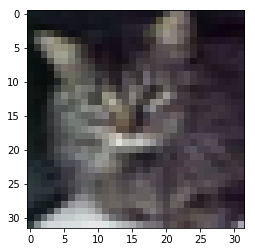

tensor(0)
<PIL.Image.Image image mode=RGB size=32x32 at 0x7F4BD40FA128>


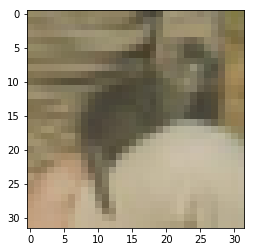

tensor(0)
<PIL.Image.Image image mode=RGB size=32x32 at 0x7F4C2D67C9B0>


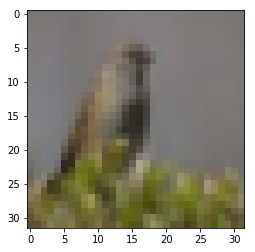

tensor(1)
<PIL.Image.Image image mode=RGB size=32x32 at 0x7F4C2640BF28>


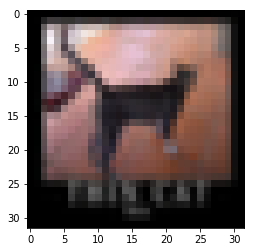

tensor(0)


In [245]:
for i, data in enumerate(trainloaders[0]):
    images, labels, _ = data
    
    break
    
trans = transforms.ToPILImage()
for i in range(4):
    a = trans(images[i].view(3,32,32))
    print(a)
    plt.imshow(a)
    plt.show()
    print(labels[i])

In [229]:
Train_set = torchvision.datasets.SVHN(root='./data', split='train')
Test_set = torchvision.datasets.SVHN(root='./data', split='test')

# Input randomization

introduce random permutation to inputs

In [16]:
bs = 256
weighting = 'paired'
trials = 10
epochs = 5000
trees_set = [1,2,4,8,16,32]
classes = np.load('./results/20200504/classes.npy', allow_pickle=True)
t1, t2, ds = classes[0]

trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds)

In [35]:
ordering = torch.randperm(len(trainloaders[0].dataset.tensors[0][0]))

256


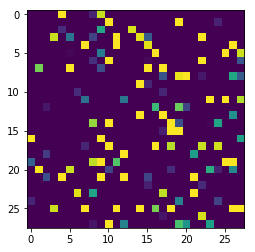

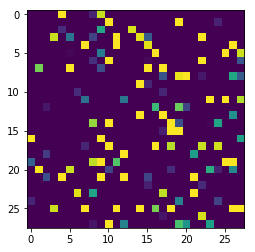

In [39]:
for i, data in enumerate(trainloaders[0]):
    inputs, labels, _ = data
    
    break
    
print(len(inputs))
a = inputs[:,ordering]
b = inputs[0,ordering]

plt.imshow(a[0].view(28,28))
plt.show()
plt.imshow(b.view(28,28))
plt.show()

In [4]:
# Select Class Set
class_set = 0

# Initialize settings
bs = 256
weighting = 'paired'
trials = 10
epochs = 50
trees_set = [1,2,4,8,16,32]

classes = np.load('./results/20200504/classes.npy', allow_pickle=True)

if class_set == 0:
    classes = classes[0:2] # mnist fmnist
elif class_set == 1:
    classes = classes[2:4] # kmnist emnist
elif class_set == 2:
    classes = classes[4:6] # svhn usps
else:
    classes = classes[6]


loss = np.zeros((len(classes), trials, len(trees_set)))
acc = np.zeros((len(classes), trials, len(trees_set)))

    
for j, (t1, t2, ds) in enumerate(classes):
    print(t1, t2, ds)
    trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds)
    for i in range(trials):
        for k, trees in enumerate(trees_set):
            print(j, i, k)
            model = ktree_gen(ds=ds, Repeats=trees).cuda()


            
            loss_curve, acc_curve, loss[j,i,k], acc[j,i,k], model_t, order = train_test_ktree(model, trainloaders[i],
                                                                                  testloader, epochs = 5000, randorder=True)
            break
        break
    break
    
            np.save('./results/20200504/k_tree_acc_'+str(class_set)+'.npy', acc)
            np.save('./results/20200504/k_tree_loss_'+str(class_set)+'.npy', loss)


IndentationError: unexpected indent (<ipython-input-4-1aaea6af987a>, line 43)

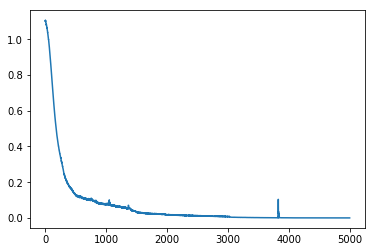

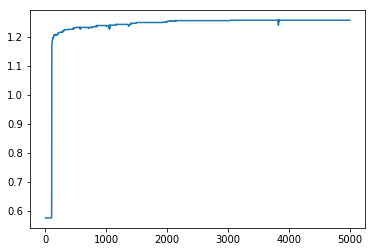

0.46898002103049424
0.01134779118001461


In [7]:
plt.plot(loss_curve)
plt.show()
plt.plot(acc_curve)
plt.show()
print(acc[0,0,0])
print(loss[0,0,0])

# Permutation (thanks David!) testing

data is permuted, next change model to take padded input (32x32)

In [5]:
# Select Class Set
class_set = 3

# Initialize settings
bs = 256
weighting = 'paired'
trials = 10
epochs = 2500
# trees_set = [1,2,4,8,16,32]
trees_set = [8]


classes = np.load('./results/20200504/classes.npy', allow_pickle=True)

if class_set == 0:
    classes = classes[0:2] # mnist fmnist
elif class_set == 1:
    classes = classes[2:4] # kmnist emnist
elif class_set == 2:
    classes = classes[4:6] # svhn usps
else:
    classes = classes[6].reshape(1,-1)


loss = np.zeros((len(classes), trials, len(trees_set)))
acc = np.zeros((len(classes), trials, len(trees_set)))

    
for j, (t1, t2, ds) in enumerate(classes):
    print(t1, t2, ds)
    trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds, permute=True)
    for i in range(trials):
        for k, trees in enumerate(trees_set):
            print(j, i, k)
            model = ktree_gen(ds=ds, Repeats=trees, Padded=True).cuda()


            
            loss_curve, acc_curve, loss[j,i,k], acc[j,i,k], model_t= train_test_ktree(model, trainloaders[i],
                                                                                  testloader, epochs = epochs, randorder=False)
            break
        break
    break
    
#             np.save('./results/20200504/k_tree_acc_'+str(class_set)+'.npy', acc)
#             np.save('./results/20200504/k_tree_loss_'+str(class_set)+'.npy', loss)


NameError: name 'np' is not defined

0.6265 3.9497616291046143


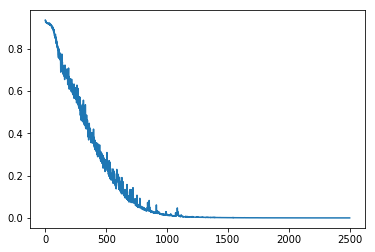

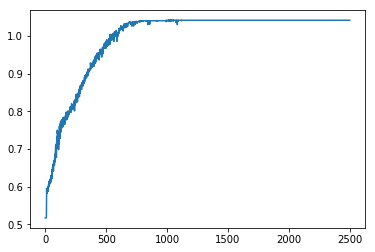

In [18]:
print(acc[0,0,0], loss[0,0,0])
plt.plot(loss_curve)
plt.show()
plt.plot(acc_curve)
plt.show()

In [19]:
# Select Class Set
class_set = 3

# Initialize settings
bs = 256
weighting = 'paired'
trials = 10
epochs = 2500
# trees_set = [1,2,4,8,16,32]
trees_set = [8]


classes = np.load('./results/20200504/classes.npy', allow_pickle=True)

if class_set == 0:
    classes = classes[0:2] # mnist fmnist
elif class_set == 1:
    classes = classes[2:4] # kmnist emnist
elif class_set == 2:
    classes = classes[4:6] # svhn usps
else:
    classes = classes[6].reshape(1,-1)


loss = np.zeros((len(classes), trials, len(trees_set)))
acc = np.zeros((len(classes), trials, len(trees_set)))

    
for j, (t1, t2, ds) in enumerate(classes):
    print(t1, t2, ds)
    trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds, permute=False)
    for i in range(trials):
        for k, trees in enumerate(trees_set):
            print(j, i, k)
            model = ktree_gen(ds=ds, Repeats=trees, Padded=False).cuda()


            
            loss_curve, acc_curve, loss[j,i,k], acc[j,i,k], model_t = train_test_ktree(model, trainloaders[i],
                                                                                  testloader, epochs = epochs, randorder=False)
            break
        break
    break
    
#             np.save('./results/20200504/k_tree_acc_'+str(class_set)+'.npy', acc)
#             np.save('./results/20200504/k_tree_loss_'+str(class_set)+'.npy', loss)


2 3 cifar10
Files already downloaded and verified
Files already downloaded and verified
0 0 0
Finished Training, 2500 epochs
Accuracy of the network on the test images: 66.100000 %


0.661 3.6970162391662598


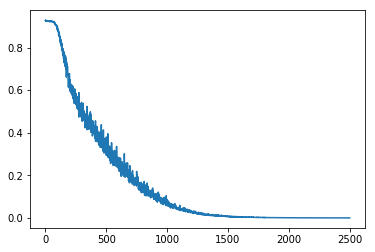

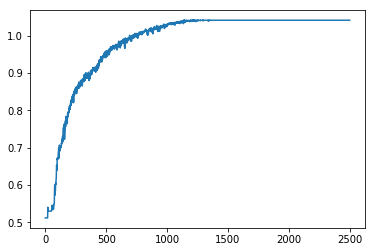

In [20]:
print(acc[0,0,0], loss[0,0,0])
plt.plot(loss_curve)
plt.show()
plt.plot(acc_curve)
plt.show()

torch.Size([256, 1024])


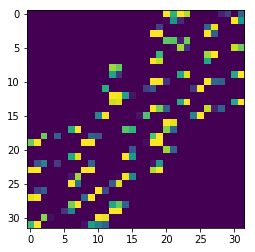

In [5]:
# Permutation works

bs = 256
t1 = 0
t2 = 1
weighting = 'paired'
trials = 10
ds = 'mnist'
permute = True

trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, 
                                                                    trials, ds, permute=True,
                                                                    padded=True)

trainloader = trainloaders[0]

for i, data in enumerate(trainloader):
    images, labels, _ = data
    
    break

print(images.shape)
plt.imshow(images[0].reshape(-1,32))

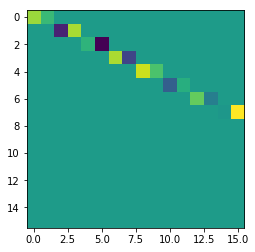

In [27]:
plt.imshow(model.w0_3.weight.data.cpu()[:16,:16])